In [16]:
import pandas as pd
df = pd.read_csv("Online Retail.csv")

In [17]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-1-2010,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-1-2010,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-1-2010,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-1-2010,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-1-2010,3.39,17850.0,United Kingdom


In [18]:
len(df)

541909

In [19]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [22]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [23]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [24]:
df.dropna(subset=['CustomerID'],inplace=True)

In [25]:
len(df)

406829

<Axes: xlabel='Quantity'>

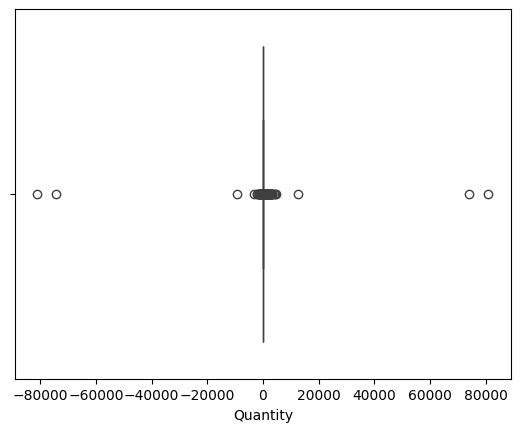

In [26]:
# checking for outliers in Quantity and UnitPrice
sns.boxplot(x=df['Quantity'])

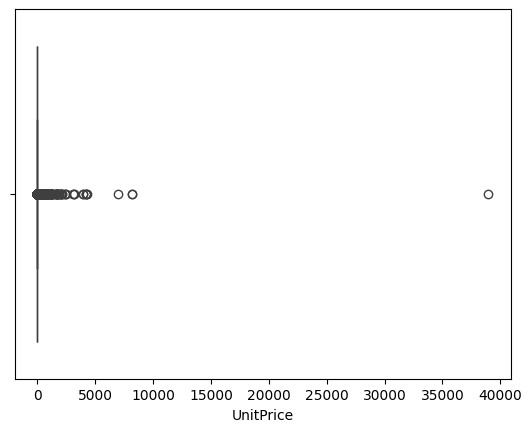

In [27]:
sns.boxplot(x=df['UnitPrice'])
plt.show()

In [28]:
df = df[(df['Quantity']>0) & (df['UnitPrice']>0)]

In [29]:
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

In [30]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [32]:
# Create reference date for recency calculation (using the day after the last transaction date)
import datetime as dt
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Calculate Recency, Frequency, and Monetary value for each customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalSpend': 'sum'  # Monetary Value
}).reset_index()

# Rename columns to RFM terms
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Display the first few rows of the RFM table
print("\nRFM Table:")
print(rfm.head())


RFM Table:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        3        182   4310.00
2     12348.0       76         31   1797.24
3     12349.0       19         73   1757.55
4     12350.0      311         17    334.40


In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [34]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

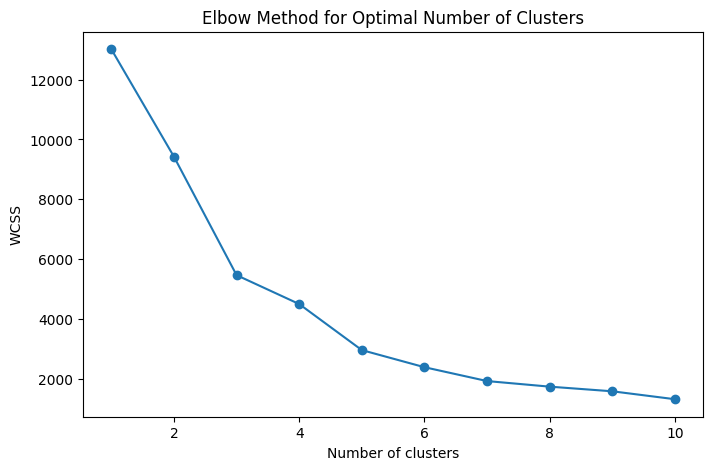

In [35]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1,11),wcss,marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [36]:
optimal_clusters = 4
kmeans = KMeans(n_clusters = optimal_clusters)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [55]:
from sklearn.metrics import silhouette_score
labels = kmeans.labels_  
silhouette_avg = silhouette_score(rfm_scaled, labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")


Silhouette Score: 0.6052


In [56]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz_avg = calinski_harabasz_score(rfm_scaled, labels)
print(f"Calinski-Harabasz Index: {calinski_harabasz_avg:.4f}")


Calinski-Harabasz Index: 3163.4346


In [40]:
kmeans.cluster_centers_

array([[-5.11498386e-01,  4.66773380e-02, -1.15756795e-02],
       [ 1.54585684e+00, -2.79362986e-01, -1.65534641e-01],
       [-9.05588078e-01,  2.49838753e+01,  7.66238678e+00],
       [-6.17733054e-01,  3.61013915e+00,  1.32595048e+01]])

In [37]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

In [38]:
centers_df = pd.DataFrame(cluster_centers, columns=['Recency','Frequency','Monetary'])
centers_df['Cluster'] = range(optimal_clusters)

In [39]:
centers_df

,Recency,Frequency,Monetary,Cluster
0,41.909259,102.398457,1950.222004,0
1,247.646296,27.813889,566.408945,1
2,2.500000,5807.000000,70925.287500,2
3,31.285714,917.571429,121233.271429,3


In [45]:
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

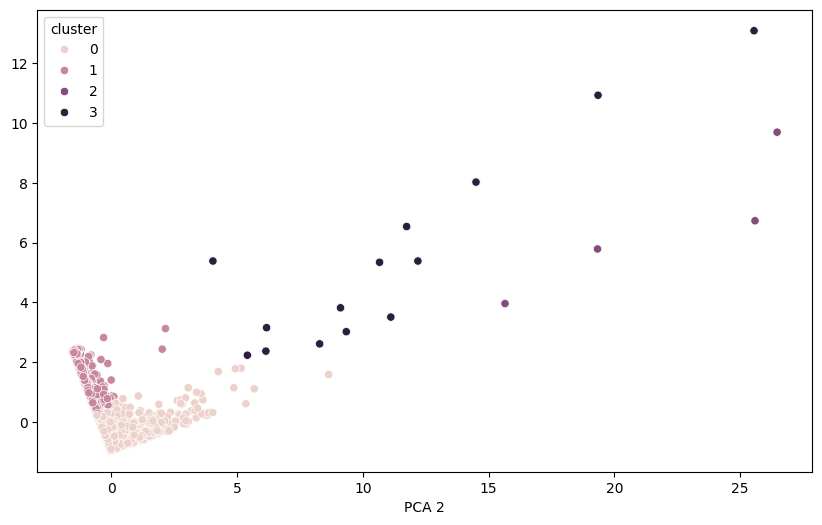

In [46]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = rfm_pca[:,0], y = rfm_pca[:,1],hue=rfm['Cluster'])
plt.xlabel('PCA 1')
plt.xlabel('PCA 2')
plt.legend(title='cluster')
plt.show()

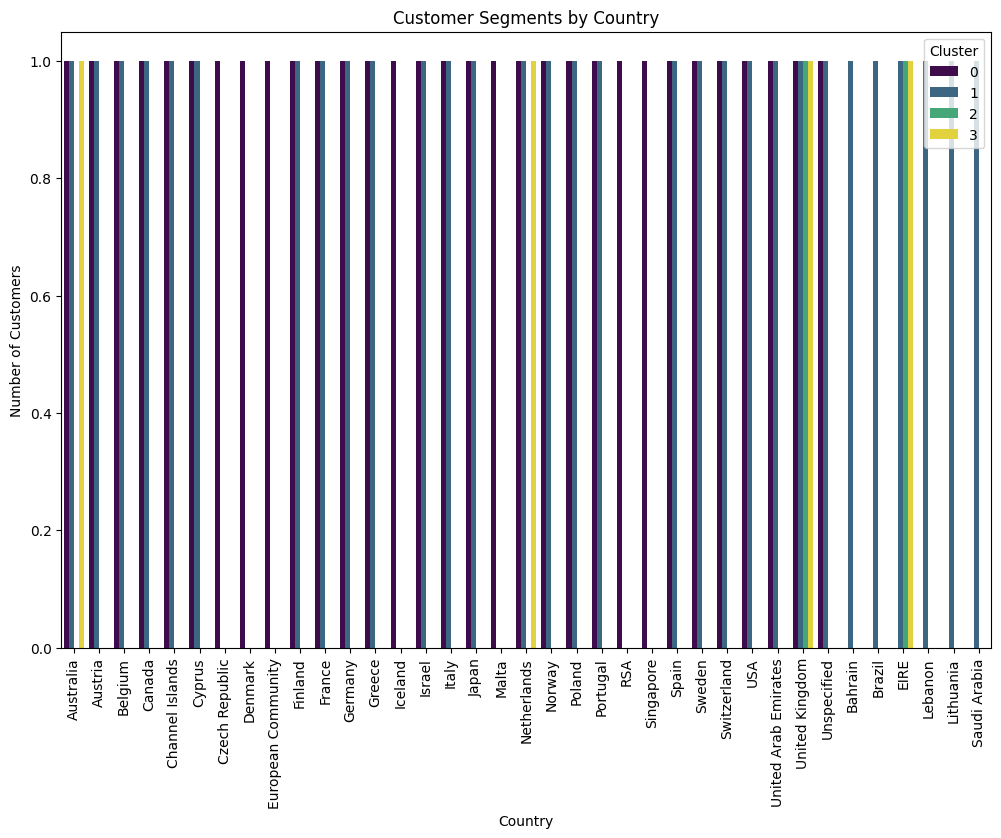

In [47]:
# Analyze the distribution of clusters across countries
cluster_country_distribution = rfm.merge(df[['CustomerID', 'Country']], on='CustomerID', how='left')
cluster_country_distribution = cluster_country_distribution.groupby(['Cluster', 'Country']).size().reset_index(name='Count')

# Plot distribution of clusters across countries
plt.figure(figsize=(12, 8))
sns.countplot(data=cluster_country_distribution, x='Country', hue='Cluster', palette='viridis')
plt.title('Customer Segments by Country')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90)
plt.legend(title='Cluster')
plt.show()


In [49]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std'],
    'CustomerID': 'count'
}).reset_index()

# Flatten MultiIndex columns
cluster_summary.columns = ['Cluster', 'Recency Mean', 'Recency Std', 'Frequency Mean', 'Frequency Std', 'Monetary Mean', 'Monetary Std', 'Customer Count']
cluster_summary.head()

,Cluster,Recency Mean,Recency Std,Frequency Mean,Frequency Std,Monetary Mean,Monetary Std,Customer Count
0,0,41.941068,35.581014,102.388769,143.245624,1950.078171,3663.500897,3241
1,1,247.741427,66.810151,27.773865,31.742950,565.558481,1928.971003,1079
2,2,2.500000,1.732051,5807.000000,1429.730044,70925.287500,50424.336433,4
3,3,31.285714,85.506121,917.571429,800.077373,121233.271429,75997.302502,14


In [50]:
for index, row in cluster_summary.iterrows():
    print(f"\nCluster {row['Cluster']}:")
    if row['Frequency Mean'] > rfm['Frequency'].mean() and row['Recency Mean'] < rfm['Recency'].mean():
        print("Characteristics: High-frequency, low-recency customers (loyal customers).")
        print("Actionable Insight: Focus on retaining these customers with exclusive offers or loyalty programs.")
    elif row['Frequency Mean'] < rfm['Frequency'].mean() and row['Recency Mean'] > rfm['Recency'].mean():
        print("Characteristics: Low-frequency, high-recency customers (new or one-time buyers).")
        print("Actionable Insight: Engage these customers with targeted marketing campaigns to increase their purchase frequency.")
    elif row['Frequency Mean'] > rfm['Frequency'].mean() and row['Recency Mean'] > rfm['Recency'].mean():
        print("Characteristics: High-frequency, high-recency customers (long-term engaged customers).")
        print("Actionable Insight: Continue to build relationships and offer value to maintain high engagement.")
    else:
        print("Characteristics: Low-frequency, low-recency customers.")
        print("Actionable Insight: Re-engage these customers through personalized outreach or promotions.")


Cluster 0.0:
Characteristics: High-frequency, low-recency customers (loyal customers).
Actionable Insight: Focus on retaining these customers with exclusive offers or loyalty programs.

Cluster 1.0:
Characteristics: Low-frequency, high-recency customers (new or one-time buyers).
Actionable Insight: Engage these customers with targeted marketing campaigns to increase their purchase frequency.

Cluster 2.0:
Characteristics: High-frequency, low-recency customers (loyal customers).
Actionable Insight: Focus on retaining these customers with exclusive offers or loyalty programs.

Cluster 3.0:
Characteristics: High-frequency, low-recency customers (loyal customers).
Actionable Insight: Focus on retaining these customers with exclusive offers or loyalty programs.


C:\Users\Acer\AppData\Local\Temp\ipykernel_8740\3475634408.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=rfm, palette='viridis')


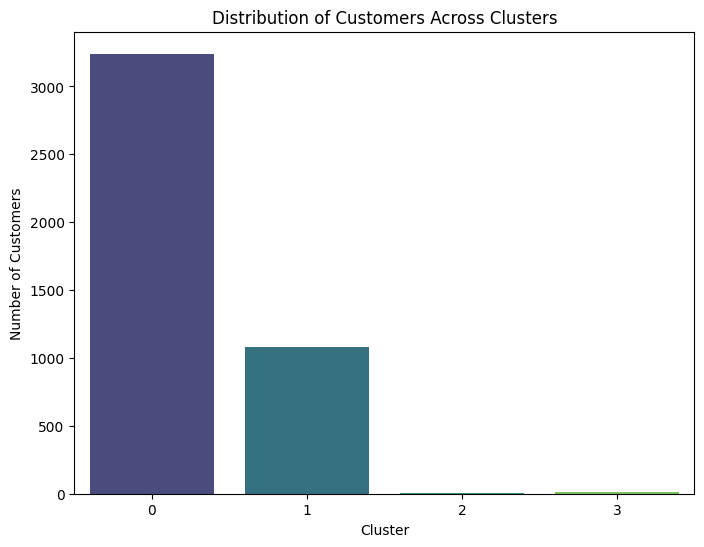

In [51]:
# Plot the distribution of customers across clusters
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', data=rfm, palette='viridis')
plt.title('Distribution of Customers Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()